In [3]:
import base64
import os
import time
from io import BytesIO
from os import path

import pandas as pd
import requests
from datasets import ClassLabel, Dataset, DatasetDict, Features, Image, Value
from PIL import Image
from selenium import webdriver
from selenium.webdriver import ActionChains
from selenium.webdriver.common.by import By
from selenium.webdriver.firefox.options import Options as FirefoxOptions

/Users/valentinaferuere/Projects/supermarket-scrapping/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Scrapping the web

In [77]:
# Url of the website to scrape
url = "https://www.jumbocolombia.com/"

In [ ]:
# Set up Firefox options for headless mode
options = FirefoxOptions()
options.headless = True
web_driver = webdriver.Firefox()
web_driver.get(url)

python(39281) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(39329) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


![image](images/menu.png)

In [84]:
# Identifies the menu bar and clicks the menu button to reveal the dropdown menu, then lists the menu items
menu_bar = web_driver.find_element(By.CLASS_NAME, "vtex-flex-layout-0-x-flexRow vtex-flex-layout-0-x-flexRow--menu-categories".replace(" ", "."))
menu_button = menu_bar.find_element(By.CLASS_NAME, "tiendasjumboqaio-jumbo-general-apps-2-x-containerTriggerButton--tigger-dropdown-mega-menu".replace(" ", "."))
menu_button.click()

menu_block = web_driver.find_element(By.CLASS_NAME, "tiendasjumboqaio-jumbo-main-menu-2-x-nav_menu".replace(" ", "."))
# print("Menu block found", menu_block.text)
menu_items = menu_block.find_elements(By.TAG_NAME, "li")
menu_items_text = [item.text for item in menu_items]
', '.join(menu_items_text)

'Supermercado, Celulares y Telefonía, Televisores y Audio, Tecnología, Electrodomésticos, Mundo bebés, Hogar y decoración, Ropa y Accesorios, Salud y Bienestar, Deportes y tiempo libre, Mascotas, Juguetería, Automóvil, Herramientas y Ferretería, Libros y Papelería, Pinturas, Pisos y Paredes, Baños, Jardín, Especiales'

![image2](images/submenu.png)

In [85]:
products_path = []
#Iterate through each menu item, click it, and extract the submenu items
for i in range(len(menu_items_text)):
    web_driver.get(url)
    time.sleep(2)  # Wait for the page to load

    menu_bar = web_driver.find_element(By.CLASS_NAME, "vtex-flex-layout-0-x-flexRow vtex-flex-layout-0-x-flexRow--menu-categories".replace(" ", "."))
    menu_button = menu_bar.find_element(By.CLASS_NAME, "tiendasjumboqaio-jumbo-general-apps-2-x-containerTriggerButton--tigger-dropdown-mega-menu".replace(" ", "."))
    menu_button.click()

    menu_block = web_driver.find_element(By.CLASS_NAME, "tiendasjumboqaio-jumbo-main-menu-2-x-nav_menu".replace(" ", "."))
    # print("Menu block found", menu_block.text)
    menu_items = menu_block.find_elements(By.TAG_NAME, "li")
    menu_items_text = [item.text for item in menu_items]

    menu_item = menu_items[i]
    category_name = menu_item.text.replace(" ", "_").replace("/", "_")
    ActionChains(web_driver).click_and_hold(menu_item).perform()

    category_products = []
    submenu_block = web_driver.find_element(By.CLASS_NAME, "tiendasjumboqaio-jumbo-main-menu-2-x-nav_menu tiendasjumboqaio-jumbo-main-menu-2-x-nav_menu--header-submenu-item tiendasjumboqaio-jumbo-main-menu-2-x-second_level tiendasjumboqaio-jumbo-main-menu-2-x-second_level--header-submenu-item".replace(" ", "."))
    submenu_items = submenu_block.find_elements(By.CLASS_NAME, "tiendasjumboqaio-jumbo-main-menu-2-x-menu_item_inner tiendasjumboqaio-jumbo-main-menu-2-x-menu_item_inner--header-submenu-item".replace(" ", "."))
    submenu_items_text = [item.text for item in submenu_items]
    products_path.append({
        "category": category_name,
        "submenu_items": submenu_items_text
    })


KeyboardInterrupt: 

In [86]:
products_path

[{'category': 'Supermercado',
  'submenu_items': ['Despensa\nArroz y granos\nAceite\nCafé\nBebida achocolatada en polvo\nCereales\nHarinas y mezclas para preparar\nPastas\nEnlatados y conservas\nAzucar, endulzantes y panelas\nChocolate de mesa\nAvenas y salvado\nCondimentos, caldos y sal\nBases, cremas y sopas\nSalsas y vinagres\nTé, infusiones e instantáneos\nVer todo despensa',
   'Arroz y granos',
   'Aceite',
   'Café',
   'Bebida achocolatada en polvo',
   'Cereales',
   'Harinas y mezclas para preparar',
   'Pastas',
   'Enlatados y conservas',
   'Azucar, endulzantes y panelas',
   'Chocolate de mesa',
   'Avenas y salvado',
   'Condimentos, caldos y sal',
   'Bases, cremas y sopas',
   'Salsas y vinagres',
   'Té, infusiones e instantáneos',
   'Lácteos, huevos y refrigerados\nLeche\nHuevos\nQueso\nArepas\nMantequilla\nMargarina\nYogurt\nKumis\nAvena\nWaffles y Crepes\nTamales\nLeches vegetales\nPostres refrigerados\nCarnes frías y embutidos\nVer todo lácteos, huevos y refriger

In [87]:
def clean_word(word):
    word = word.replace(" ", "-")
    word = word.replace("/", "_")
    word = word.replace(",", "")
    word = word.replace("á", "a")
    word = word.replace("é", "e")
    word = word.replace("í", "i")
    word = word.replace("ó", "o")
    word = word.replace("ú", "u")
    word = word.lower()
    return word

In [ ]:
# Identifies all the subcategories and builds a list of paths, each path is a combination of the category and subcategory 
paths = []

for item in products_path:
    category = clean_word(item["category"])
    submenu_items = item["submenu_items"]
    subcategory = ""
    for submenu_item in submenu_items:
        if "\n" in submenu_item:
            subcategory = clean_word(submenu_item.split("\n")[0])
        else:
            path_for_subcategory = path.join(category, subcategory, clean_word(submenu_item))
            paths.append(path_for_subcategory)
paths[:10]

['supermercado/despensa/arroz-y-granos',
 'supermercado/despensa/aceite',
 'supermercado/despensa/cafe',
 'supermercado/despensa/bebida-achocolatada-en-polvo',
 'supermercado/despensa/cereales',
 'supermercado/despensa/harinas-y-mezclas-para-preparar',
 'supermercado/despensa/pastas',
 'supermercado/despensa/enlatados-y-conservas',
 'supermercado/despensa/azucar-endulzantes-y-panelas',
 'supermercado/despensa/chocolate-de-mesa']

In [90]:
def close_popup():
    popup = web_driver_path.find_element(By.CLASS_NAME, "tiendasjumboqaio-delivery-modal-3-x-locationVerificationAd")
    if popup.is_displayed():
        print("Popup is displayed, closing it.")
        close_button = popup.find_element(By.CLASS_NAME, "tiendasjumboqaio-delivery-modal-3-x-locationVerificationAd__close")
        close_button.click()

![image3](images/products.png)

In [ ]:
# Scrape products from each path
products = []

for product_category_path in paths:
    products_path = path.join(url, product_category_path)
    web_driver_path = webdriver.Firefox()
    # Headless mode can be enabled by uncommenting the next line
    web_driver_path.get(products_path)

    time.sleep(2)  # Wait for the page to load

    # Scroll to the bottom of the page to load all products
    web_driver_path.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(0.5) 
    # web_driver_path.execute_script("window.scrollTo(0, document.body.scrollHeight);") # Wait for the page to load
    # time.sleep(0.5)  # Wait for the page to load
    pages = web_driver_path.find_elements(By.CLASS_NAME, "tiendasjumboqaio-jumbo-fetch-more-paginator-0-x-buttonPerPage".replace(" ", "."))


    for page_i in range(len(pages)):
        product_items = web_driver_path.find_elements(By.CLASS_NAME, "tiendasjumboqaio-cmedia-integration-cencosud-1-x-galleryItem tiendasjumboqaio-cmedia-integration-cencosud-1-x-galleryItem--gallery-css tiendasjumboqaio-cmedia-integration-cencosud-1-x-galleryItem--normal tiendasjumboqaio-cmedia-integration-cencosud-1-x-galleryItem--gallery-css--normal tiendasjumboqaio-cmedia-integration-cencosud-1-x-galleryItem--grid tiendasjumboqaio-cmedia-integration-cencosud-1-x-galleryItem--gallery-css--grid pa4".replace(" ", "."))
        for product in product_items:
            product_name = product.find_element(By.CLASS_NAME, "vtex-product-summary-2-x-productBrand vtex-product-summary-2-x-brandName t-body".replace(" ", ".")).text
            product_image = product.find_element(By.TAG_NAME, "img").get_attribute("src")
            products.append({"name": product_name, "image": product_image, "category": product_category_path})

        paginator = web_driver_path.find_element(By.CLASS_NAME, "tiendasjumboqaio-jumbo-fetch-more-paginator-0-x-buttonShowMore--layout".replace(" ", "."))
        pages = web_driver_path.find_elements(By.CLASS_NAME, "tiendasjumboqaio-jumbo-fetch-more-paginator-0-x-buttonPerPage")
        print(f"Clicking on page {page_i + 1} of {len(pages)}")

        #It may be necessary to close a popup that appears when clicking on the page, the black popup in the left bottom corner
        close_popup()

        pages[page_i].click() 
        web_driver_path.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2) 
    
        print(f"Products in {product_category_path}: {len(products)}")
    web_driver_path.quit()

python(39922) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(39963) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Clicking on page 1 of 7
Popup is displayed, closing it.
Products in supermercado/despensa/arroz-y-granos: 20
Clicking on page 2 of 7
Products in supermercado/despensa/arroz-y-granos: 48
Clicking on page 3 of 7
Products in supermercado/despensa/arroz-y-granos: 76


KeyboardInterrupt: 

In [93]:
products

[{'name': 'Arroz Diana blanco x10kg ',
  'image': 'https://jumbocolombiaio.vtexassets.com/arquivos/ids/659910-300-300?v=638599488512130000&width=300&height=300&aspect=true',
  'category': 'supermercado/despensa/arroz-y-granos'},
 {'name': 'Arroz Diana blanco x5kg ',
  'image': 'https://jumbocolombiaio.vtexassets.com/arquivos/ids/186323-300-300?v=637813981860700000&width=300&height=300&aspect=true',
  'category': 'supermercado/despensa/arroz-y-granos'},
 {'name': 'Arroz Sonora x10kg ',
  'image': 'https://jumbocolombiaio.vtexassets.com/arquivos/ids/660331-300-300?v=638604589891570000&width=300&height=300&aspect=true',
  'category': 'supermercado/despensa/arroz-y-granos'},
 {'name': 'Arroz Diana blanco x3kg ',
  'image': 'https://jumbocolombiaio.vtexassets.com/arquivos/ids/186321-300-300?v=637813981854430000&width=300&height=300&aspect=true',
  'category': 'supermercado/despensa/arroz-y-granos'},
 {'name': 'Arroz Diana Premium blanco x4000g ',
  'image': 'https://jumbocolombiaio.vtexasse

In [124]:
df = pd.DataFrame(products)
df

,name,image,category
0,Arroz Diana blanco x10kg,https://jumbocolombiaio.vtexassets.com/arquivo...,supermercado/despensa/arroz-y-granos
1,Arroz Diana blanco x5kg,https://jumbocolombiaio.vtexassets.com/arquivo...,supermercado/despensa/arroz-y-granos
2,Arroz Sonora x10kg,https://jumbocolombiaio.vtexassets.com/arquivo...,supermercado/despensa/arroz-y-granos
3,Arroz Diana blanco x3kg,https://jumbocolombiaio.vtexassets.com/arquivo...,supermercado/despensa/arroz-y-granos
4,Arroz Diana Premium blanco x4000g,https://jumbocolombiaio.vtexassets.com/arquivo...,supermercado/despensa/arroz-y-granos
...,...,...,...
71,Arroz Roa 10 x2.5kg,https://jumbocolombiaio.vtexassets.com/arquivo...,supermercado/despensa/arroz-y-granos
72,Garbanzo Diana seleccionados x1000g,https://jumbocolombiaio.vtexassets.com/arquivo...,supermercado/despensa/arroz-y-granos
73,Arroz Castellano Premium basmati x500g,https://jumbocolombiaio.vtexassets.com/arquivo...,supermercado/despensa/arroz-y-granos
74,Arroz Castellano Premium integral x1000g,https://jumbocolombiaio.vtexassets.com/arquivo...,supermercado/despensa/arroz-y-granos


In [125]:
df["supermarket_category"] = df["category"].apply(lambda x: x.split("/")[0] if "/" in x else x)
df["main_category"] = df["category"].apply(lambda x: x.split("/")[1] if "/" in x else "")
df["subcategory"] = df["category"].apply(lambda x: x.split("/")[2] if "/" in x else "")

In [126]:
df.sample(10)

,name,image,category,supermarket_category,main_category,subcategory
50,Arroz Diana integral x1000g,https://jumbocolombiaio.vtexassets.com/arquivo...,supermercado/despensa/arroz-y-granos,supermercado,despensa,arroz-y-granos
62,Arroz Florhuila Platino blanco x2.5kg,https://jumbocolombiaio.vtexassets.com/arquivo...,supermercado/despensa/arroz-y-granos,supermercado,despensa,arroz-y-granos
39,Frijol Cuisine&Co bola roja x1000g,https://jumbocolombiaio.vtexassets.com/arquivo...,supermercado/despensa/arroz-y-granos,supermercado,despensa,arroz-y-granos
16,Lenteja Cuisine&Co x1kg,https://jumbocolombiaio.vtexassets.com/arquivo...,supermercado/despensa/arroz-y-granos,supermercado,despensa,arroz-y-granos
74,Arroz Castellano Premium integral x1000g,https://jumbocolombiaio.vtexassets.com/arquivo...,supermercado/despensa/arroz-y-granos,supermercado,despensa,arroz-y-granos
37,Arroz Doña Pepa parbolizado x3000g,https://jumbocolombiaio.vtexassets.com/arquivo...,supermercado/despensa/arroz-y-granos,supermercado,despensa,arroz-y-granos
44,Lenteja Cuisine&Co x1kg,https://jumbocolombiaio.vtexassets.com/arquivo...,supermercado/despensa/arroz-y-granos,supermercado,despensa,arroz-y-granos
54,Arveja Maritza Premium x500g,https://jumbocolombiaio.vtexassets.com/arquivo...,supermercado/despensa/arroz-y-granos,supermercado,despensa,arroz-y-granos
25,Arroz Diana blanco x25und x500g c-u,https://jumbocolombiaio.vtexassets.com/arquivo...,supermercado/despensa/arroz-y-granos,supermercado,despensa,arroz-y-granos
4,Arroz Diana Premium blanco x4000g,https://jumbocolombiaio.vtexassets.com/arquivo...,supermercado/despensa/arroz-y-granos,supermercado,despensa,arroz-y-granos


In [100]:
!mkdir dataset

python(40306) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [105]:
IMAGES_PATH = "dataset/train"
#Download images from the URLs in the DataFrame
for index, row in df.iterrows():
    product_id = index
    image_url = row["image"]
    image_name = str(product_id) + ".webp"
    image_path = path.join(IMAGES_PATH, image_name)

    if not path.exists(IMAGES_PATH):
        os.makedirs(IMAGES_PATH)

    if not path.exists(image_path):
        print(f"Downloading {image_name}...")
        response = requests.get(image_url)
        with open(image_path, "wb") as file:
            file.write(response.content)
    else:
        print(f"{image_name} already exists, skipping download.")


KeyboardInterrupt: 

In [127]:
df["full_image_path"] = df.index.map(lambda x: path.join(IMAGES_PATH, f"{x}.webp"))
df["file_name"] = df.index.map(lambda x:  f"{x}.webp")

In [128]:
df

,name,image,category,supermarket_category,main_category,subcategory,full_image_path,file_name
0,Arroz Diana blanco x10kg,https://jumbocolombiaio.vtexassets.com/arquivo...,supermercado/despensa/arroz-y-granos,supermercado,despensa,arroz-y-granos,dataset/train/0.webp,0.webp
1,Arroz Diana blanco x5kg,https://jumbocolombiaio.vtexassets.com/arquivo...,supermercado/despensa/arroz-y-granos,supermercado,despensa,arroz-y-granos,dataset/train/1.webp,1.webp
2,Arroz Sonora x10kg,https://jumbocolombiaio.vtexassets.com/arquivo...,supermercado/despensa/arroz-y-granos,supermercado,despensa,arroz-y-granos,dataset/train/2.webp,2.webp
3,Arroz Diana blanco x3kg,https://jumbocolombiaio.vtexassets.com/arquivo...,supermercado/despensa/arroz-y-granos,supermercado,despensa,arroz-y-granos,dataset/train/3.webp,3.webp
4,Arroz Diana Premium blanco x4000g,https://jumbocolombiaio.vtexassets.com/arquivo...,supermercado/despensa/arroz-y-granos,supermercado,despensa,arroz-y-granos,dataset/train/4.webp,4.webp
...,...,...,...,...,...,...,...,...
71,Arroz Roa 10 x2.5kg,https://jumbocolombiaio.vtexassets.com/arquivo...,supermercado/despensa/arroz-y-granos,supermercado,despensa,arroz-y-granos,dataset/train/71.webp,71.webp
72,Garbanzo Diana seleccionados x1000g,https://jumbocolombiaio.vtexassets.com/arquivo...,supermercado/despensa/arroz-y-granos,supermercado,despensa,arroz-y-granos,dataset/train/72.webp,72.webp
73,Arroz Castellano Premium basmati x500g,https://jumbocolombiaio.vtexassets.com/arquivo...,supermercado/despensa/arroz-y-granos,supermercado,despensa,arroz-y-granos,dataset/train/73.webp,73.webp
74,Arroz Castellano Premium integral x1000g,https://jumbocolombiaio.vtexassets.com/arquivo...,supermercado/despensa/arroz-y-granos,supermercado,despensa,arroz-y-granos,dataset/train/74.webp,74.webp


In [129]:
#Store dataset metadata
df[["name", "supermarket_category", "main_category", "subcategory"]].to_csv("dataset/train/metadata.csv")

In [17]:
import oci
print(oci.__version__)

2.154.3


In [18]:
def convert_image_to_base64(image: Image):
    """"
    Converts an image to a base64 encoded string.
    """
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    try:
        base64_image = base64.b64encode(buffered.getvalue()).decode("utf-8")
        base64_image_url = f"data:image/jpeg;base64,{base64_image}"
        return base64_image_url
    except Exception as e:
        raise ValueError(f"Erro ao acessar a imagem")
   
   
def create_image_content_message(image):
    """
    Creates an ImageContent message for the OCI Generative AI Inference service.
    """
    base64_image_url = convert_image_to_base64(image)
    imagem = oci.generative_ai_inference.models.ImageContent()
    image_url_content = oci.generative_ai_inference.models.ImageUrl()
    image_url_content.url = base64_image_url
    imagem.image_url = image_url_content
    return imagem

def create_text_content_message(text):
    """
    Creates a TextContent message for the OCI Generative AI Inference service.
    """
    texto = oci.generative_ai_inference.models.TextContent()
    texto.text = text

    return texto

def create_list_of_messages(messages):
    """
    Converts a list of messages into a format suitable for the OCI Generative AI Inference service.
    Each message should have a role and content, where content can be text or image.
    """
    messages_content_for_chat = []
    for message in messages:
        message_for_chat = oci.generative_ai_inference.models.UserMessage()
        message_for_chat.role = message["role"]

        for messages_content in message["messages"]:
            message_content = []
            if "text" in messages_content:
                texto = create_text_content_message(messages_content["text"])
                message_content.append(texto)
            if "image" in messages_content:
                imagem = create_image_content_message(messages_content["image"])
                message_content.append(imagem)
        message_for_chat.content = message_content
        messages_content_for_chat.append(message_for_chat)
    
    return messages_content_for_chat

[{
   "content": [
     {
       "image_url": {
         "detail": null,
         "url": ""
       },
       "type": "IMAGE"
     }
   ],
   "name": null,
   "role": "USER"
 },
 {
   "content": [
     {
       "text": "\"\nEres un experto en productos de supermercado. A partir de la descripción de los productos que haces, los usuarios pueden navegar e identificar productos similares, por lo que es importante que describas el contenido del paquete y no te enfoques en el paquete.\nLa presentación del producto es importante, no te enfoques en los colores y la marca, sino en la forma, el tamaño y la cantidad de productos que hay en el paquete.\nDescribe el producto de la imagen que te enviaré a continuación. \nNo incluyas información sobre la marca, el precio o el lugar donde se vende.\nSolo describe el producto en sí, su forma, tamaño y cantidad.\n",
       "type": "TEXT"
     }
   ],
   "name": null,
   "role": "USER"
 }]
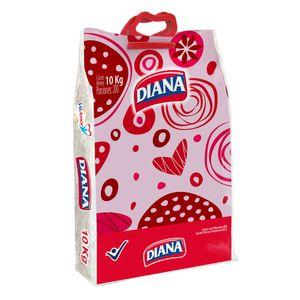

In [19]:
PROMPT = """"
Eres un experto en productos de supermercado. A partir de la descripción de los productos que haces, los usuarios pueden navegar e identificar productos similares, por lo que es importante que describas el contenido del paquete y no te enfoques en el paquete.
La presentación del producto es importante, no te enfoques en los colores y la marca, sino en la forma, el tamaño y la cantidad de productos que hay en el paquete.
Describe el producto de la imagen que te enviaré a continuación. 
No incluyas información sobre la marca, el precio o el lugar donde se vende.
Solo describe el producto en sí, su forma, tamaño y cantidad.
"""

image = Image.open(df["full_image_path"].iloc[0])
messages = create_list_of_messages([
    {
        "role": "USER",
        "messages": [
            {"image": image}
        ]
    },
    {
        "role": "USER",
        "messages": [
            {"text": PROMPT},
        ]
    }
])
messages

In [20]:
config = oci.config.from_file("~/.oci/config", "DEFAULT")
signer = oci.signer.Signer(
    tenancy=config["tenancy"],
    user=config["user"],
    fingerprint=config["fingerprint"],
    private_key_file_location=config["key_file"],
    pass_phrase=config.get("pass_phrase")
)

endpoint = "https://inference.generativeai.us-chicago-1.oci.oraclecloud.com"
generative_ai_inference_client = oci.generative_ai_inference.GenerativeAiInferenceClient(
    config=config,
    signer=signer,
    service_endpoint=endpoint,
    retry_strategy=oci.retry.NoneRetryStrategy(),
    timeout=(100, 240)
)

In [21]:
def inference(messages):
    # Configuration of the chat request
    chat_request = oci.generative_ai_inference.models.GenericChatRequest()
    chat_request.api_format = oci.generative_ai_inference.models.BaseChatRequest.API_FORMAT_GENERIC
    chat_request.messages = messages
    chat_request.num_generations = 1
    chat_request.is_stream = False
    chat_request.max_tokens = 4000
    chat_request.temperature = 0.5
    chat_request.frequency_penalty = 0
    chat_request.presence_penalty = 0
    chat_request.top_p = 0.5
    chat_request.top_k = 1

    # Configuration of the chat details
    chat_detail = oci.generative_ai_inference.models.ChatDetails()
    chat_detail.serving_mode = oci.generative_ai_inference.models.OnDemandServingMode(
        model_id="meta.llama-4-maverick-17b-128e-instruct-fp8"
    )
    chat_detail.chat_request = chat_request
    chat_detail.compartment_id = "ocid1.compartment.oc1..aaaaaaaafaniufr3t6azq5kzu4nfwcjvg4t2whrdbfa75kfqjpdjlxefbouq"

    # Perform the inference
    chat_response = generative_ai_inference_client.chat(chat_detail)

    # Process the response
    choices = chat_response.data.chat_response.choices
    if choices and len(choices) > 0:
        response_text = choices[0].message.content[0].text
    else:
        response_text = "No response generated."
    return response_text

In [22]:
%%time
inference(messages)

CPU times: user 21.7 ms, sys: 21.9 ms, total: 43.7 ms
Wall time: 2.73 s


'El producto es un tipo de alimento presentado en una bolsa flexible con asa para facilitar su transporte. La cantidad contenida en la bolsa es de 10 kilogramos. \n\nEl producto en sí no se puede identificar claramente debido a la imagen proporcionada, pero se puede inferir que es un producto granular o en polvo debido a la forma en que está empaquetado. La bolsa está diseñada para contener productos a granel, lo que sugiere que el contenido es algo que se vende por peso.\n\nLa forma del contenido no se puede determinar con precisión, pero es probable que sea un producto alimenticio como azúcar, harina o algún otro tipo de grano o polvo comestible. El tamaño del paquete es considerable, lo que indica que está destinado a uso comercial o para grandes consumidores.'

In [23]:
df = pd.read_csv("dataset/train/metadata.csv")
df

,file_name,name,supermarket_category,main_category,subcategory
0,0.webp,Arroz Diana blanco x10kg,supermercado,despensa,arroz-y-granos
1,1.webp,Arroz Diana blanco x5kg,supermercado,despensa,arroz-y-granos
2,2.webp,Arroz Sonora x10kg,supermercado,despensa,arroz-y-granos
3,3.webp,Arroz Diana blanco x3kg,supermercado,despensa,arroz-y-granos
4,4.webp,Arroz Diana Premium blanco x4000g,supermercado,despensa,arroz-y-granos
...,...,...,...,...,...
7444,7446.webp,Desodorante Antitranspirante Rexona Men Motion...,supermercado,cuidado-personal,desodorantes
7445,7447.webp,Desodorante Aclarante Nivea Tono Natural Class...,supermercado,cuidado-personal,desodorantes
7446,7448.webp,Desodorante Balance Mini Crema Clinical Protec...,supermercado,cuidado-personal,desodorantes
7447,7449.webp,Desodorante Hombre Speed Stick Xtreme Night Ge...,supermercado,cuidado-personal,desodorantes


In [24]:
df["full_image_path"] = df.index.map(lambda x: path.join("dataset/train", f"{x}.webp"))

In [25]:
# add null column 'ai_generated_description' to the DataFrame
df["ai_generated_description"] = pd.NA

In [29]:
MAX_RETRIES = 3
retries_failed = 0
for index, row in df[df["ai_generated_description"].isnull()].sample(frac=1).iterrows():
    try:
        print(f"Processing product {index + 1} of {len(df)}: {row['name']}")
        product_id = index
        image_path = row["full_image_path"]
        image = Image.open(image_path)

        messages = create_list_of_messages([
            {
                "role": "USER",
                "messages": [
                    {"image": image}
                ]
            },
            {
                "role": "USER",
                "messages": [
                    {"text": PROMPT},
                ]
            }
        ])
        
        response_text = inference(messages)
        df.at[index, "ai_generated_description"] = response_text
        retries_failed = 0  # Reset retries on success
    except Exception as e:
        print(f"Error processing product {index + 1}: {e}, skipping to the next product.")
        retries_failed += 1
        if retries_failed >= MAX_RETRIES:
            print(f"Max retries reached for product {index + 1}. Stopping further processing.")
            break

Processing product 4611 of 7449: Rollitos Cuisine&Co bocadillo rellenos x10undx200g 
Processing product 378 of 7449: Cápsulas de Café Juan Valdez 
Processing product 6505 of 7449: Cerveza asahi super dry x330ml 
Processing product 5095 of 7449: Uva pasa blanca x 150 gr 
Processing product 2263 of 7449: Alimento Lacteo Bon Yurt Surtido 8Un 1380g 
Error processing product 2263: cannot write mode P as JPEG, skipping to the next product.
Processing product 5366 of 7449: Galletas Tosh fusión cereales x2 tacos x388g 
Processing product 97 of 7449: Arroz Florhuila integral x1kg 
Processing product 697 of 7449: Mezcla Pan para arepas de choclo x850g 
Processing product 4255 of 7449: Chocolate Lok caja premium variada x24 undx120g 
Error processing product 4255: cannot write mode P as JPEG, skipping to the next product.
Processing product 4789 of 7449: Pasabocas Alpina Queso Parmesano x23g 
Processing product 1128 of 7449: Panela Fonce cuadrada x1125g 
Processing product 3213 of 7449: Palmitos 

In [30]:
df[~df["ai_generated_description"].isnull()]

,file_name,name,supermarket_category,main_category,subcategory,full_image_path,ai_generated_description
0,0.webp,Arroz Diana blanco x10kg,supermercado,despensa,arroz-y-granos,dataset/train/0.webp,"El producto es azúcar en forma de perlas, pres..."
1,1.webp,Arroz Diana blanco x5kg,supermercado,despensa,arroz-y-granos,dataset/train/1.webp,El producto es un paquete que contiene arroz b...
2,2.webp,Arroz Sonora x10kg,supermercado,despensa,arroz-y-granos,dataset/train/2.webp,"El producto es arroz, presentado en una bolsa...."
3,3.webp,Arroz Diana blanco x3kg,supermercado,despensa,arroz-y-granos,dataset/train/3.webp,El producto es un paquete que contiene arroz b...
4,4.webp,Arroz Diana Premium blanco x4000g,supermercado,despensa,arroz-y-granos,dataset/train/4.webp,El producto es arroz blanco contenido en una b...
...,...,...,...,...,...,...,...
7443,7445.webp,Desodorante Antitranspirante Hombre Gillette S...,supermercado,cuidado-personal,desodorantes,dataset/train/7443.webp,El producto es una crema en un tubo con tapa. ...
7444,7446.webp,Desodorante Antitranspirante Rexona Men Motion...,supermercado,cuidado-personal,desodorantes,dataset/train/7444.webp,El producto de la imagen es un desodorante en ...
7445,7447.webp,Desodorante Aclarante Nivea Tono Natural Class...,supermercado,cuidado-personal,desodorantes,dataset/train/7445.webp,El producto es un desodorante en barra invisib...
7446,7448.webp,Desodorante Balance Mini Crema Clinical Protec...,supermercado,cuidado-personal,desodorantes,dataset/train/7446.webp,El producto de la imagen es un desodorante en ...


In [31]:
1 - (df["ai_generated_description"].isnull().sum() / len(df))

np.float64(0.8336689488521949)

In [32]:
df[["name", "supermarket_category", "main_category", "subcategory"]].to_csv("dataset/train/metadata.csv")

In [37]:
# Remove ; from the file name
df["name"] = df["name"].str.replace(";", "_")
df["ai_generated_description"] = df["ai_generated_description"].str.replace(";", "_")

In [38]:
df[["name", "ai_generated_description"]].to_csv("products.csv", index=False, sep=";")

In [36]:
pd.read_csv("products.csv")

,name,ai_generated_description
0,Arroz Diana blanco x10kg,"El producto es azúcar en forma de perlas, pres..."
1,Arroz Diana blanco x5kg,El producto es un paquete que contiene arroz b...
2,Arroz Sonora x10kg,"El producto es arroz, presentado en una bolsa...."
3,Arroz Diana blanco x3kg,El producto es un paquete que contiene arroz b...
4,Arroz Diana Premium blanco x4000g,El producto es arroz blanco contenido en una b...
...,...,...
7444,Desodorante Antitranspirante Rexona Men Motion...,El producto de la imagen es un desodorante en ...
7445,Desodorante Aclarante Nivea Tono Natural Class...,El producto es un desodorante en barra invisib...
7446,Desodorante Balance Mini Crema Clinical Protec...,El producto de la imagen es un desodorante en ...
7447,Desodorante Hombre Speed Stick Xtreme Night Ge...,El producto de la imagen son dos unidades de d...
